In [50]:
# demonstrate difference between rasterio 0.36 and 1.10
# I suspect that transform works differently.
# - extract geom, plot
# - print transform matrix. That one differs, by some seemingly irregular amount.
# - transform a point

# NEXT: run retrieve, quick session, in both 0.36 and 1.10? Mhh, would need to roll back to py2.7 version.

In [51]:
import sys
sys.path.append("../")

In [52]:
import common
import geopandas
import rasterio
import rasterio.mask
import rasterio.plot
import os.path
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
import shapely
import shapely.geometry
from affine import Affine
from pdb import pm
import logging
from textwrap import dedent
import string
#import pub

In [53]:
rasterio.__version__

'1.0.13'

In [54]:
# FIXME: OS-independent path
base = "/home/albrecht/tmp/landscape/"
#base = "/home/albrecht/mh/tmp/landscape/"
path_to_landforms_shp = base + "landforms/Landforms_2018_04_26.shp"
#path_to_tifs = base + "tmp/AFOquarter_s9_Landforms_2018_04_26/"
#path_to_tifs = base + "tmp/AFOlessquarter_s9_Landforms_2018_04_26/"
#path_to_tifs = base + "tmp/AFOlessquarter_s3_Landforms_2018_04_26/" # geoms[4:]
#path_to_tifs = base + "tmp/AFO_s9_Landforms_2018_04_26/"
path_to_tifs = base + "tmp/AFO_s27_Landforms_2018_04_26"
#path_to_tifs = base + "tmp/AFO_s3_Landforms_2018_04_26"

shapefile = geopandas.read_file(path_to_landforms_shp)
orig_geoms = shapefile.geometry.values # list of shapely geometries
#geoms = geoms[0:3] # use just two classes
#geoms = [geoms[4], geoms[6], geoms[8]]
#geoms = [geoms[4], geoms[5], geoms[6],  geoms[7], geoms[8]]
#geoms = [geoms[4], geoms[8]]



# In[18]:

In [55]:
filename = os.path.join(path_to_tifs, "mrvbf.tif")
src = rasterio.open(filename)


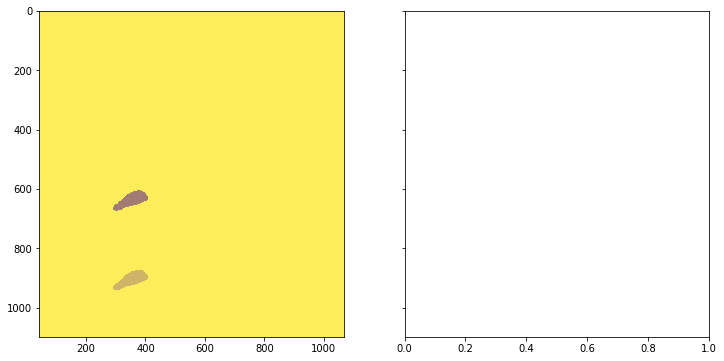

In [56]:
the_geom = orig_geoms[5]
geoms = [the_geom]

class_JSON = [shapely.geometry.mapping(the_geom)]

# Funny. This returns a masked array, but mask is all False?!
cropped_ma, cropped_transform = rasterio.mask.mask(src, class_JSON, crop=False, invert=False)
cropped_ma = cropped_ma.squeeze() # if src is single-band, remove useless dimension

fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
ax0.imshow(cropped_ma, alpha=0.5)
#plt.colorbar(ax0)

####
# display
import shapely.affinity
the_geom = shapely.affinity.translate(the_geom, xoff=0.0, yoff=2.0, zoff=0.0)
#geoms = [the_geom, geoms[6]]
geoms = [the_geom]


class_JSON = [shapely.geometry.mapping(the_geom)]

# Funny. This returns a masked array, but mask is all False?!
cropped_ma, cropped_transform = rasterio.mask.mask(src, class_JSON, crop=False, invert=False)
cropped_ma = cropped_ma.squeeze() # if src is single-band, remove useless dimension

ax0.imshow(cropped_ma, alpha=0.5)


In [57]:
assert isinstance(cropped_ma, np.ma.core.MaskedArray)

AssertionError: 

(1098, 1111)
mask bounds (119.48607033875487, -31.956776363962888, 120.36677153411438, -31.439171275462172)


IndexError: too many indices for array

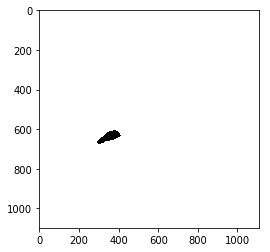

In [58]:
print (cropped_ma.shape)
#print (cropped_ma.mask.sum())

import matplotlib.cm as cm
plt.imshow(cropped_ma.data, cmap=cm.gray)
src.nodata

all_bounds = [rasterio.features.bounds(shape) for shape in class_JSON]
minxs, minys, maxxs, maxys = zip(*all_bounds)
mask_bounds = (min(minxs), min(minys), max(maxxs), max(maxys)) # in lat, lon
print ("mask bounds", mask_bounds)

# draw rect as min bounding box
win = np.array(src.window(*mask_bounds))
rect = plt.Rectangle((win[1,0], win[0,0]), win[1,1]-win[1,0], win[0,1]-win[0,0],
                    linewidth=1,edgecolor='r',facecolor='none')
plt.gca().add_patch(rect)

In [59]:
all_bounds

[(119.48607033875487,
  -31.956776363962888,
  120.36677153411438,
  -31.439171275462172)]

In [60]:
win

array(Window(col_off=292.8093785006495, row_off=605.2228367282901, width=117.42682604793481, height=69.01401180009543),
      dtype=object)

In [61]:
if 0:
    crop = True
    invert = False
    raster = src
    if crop:
        window = raster.window(*mask_bounds)
        out_transform = raster.window_transform(window)
    else:
        window = None
        out_transform = raster.affine



    # extend mask_bounds by block_size/2
    ##TODO



    # Returns the window corresponding to the world bounding box.
    # That is, our pixel data block. Unmasked yet.
    # mask_bounds is lat, lon; window is px
    window = src.window(*mask_bounds)
    img = src.read(window=window, masked=True)

    # apply mask
    shape_mask = rasterio.mask.geometry_mask(class_JSON, transform=out_transform, invert=invert,
                               out_shape=out_shape, all_touched=all_touched)
    out_image.mask = out_image.mask | shape_mask
    out_image.fill_value = nodata

    img.shape

In [62]:
def mask_extend(raster, shapes, extend_pixel, nodata=None, crop=False, all_touched=False,
                invert=False, crop_to_shape=True):
    """This reimplements rasterio.mask.mask, with two added features:
       1. Extend the bounding box of `shapes` by `extend_pixel`.

          rasterio.mask.mask returns a (rectangular) bounding box that tighly
          encloses `shapes`. If we want to extract a kernel which overlaps the
          `shapes` boundary, we need a band of additional data beyond `shape`.

       2. `crop_to_shape` controls whether or not to crop extended bounding box
          to the actual shapes.

          If False, return a matrix matching the extended bounding box, with
          all valid data.

          If True (Default), return the same matrix but mask out locations
          outside `shapes`. This matches the behaviour of rasterio.mask.mask().

          Note that `crop_to_shape` is different from `crop`, which controls
          whether or not the result is cropped to bbox, or returned in the shape
          of the entire map.
    """
    if len(extend_pixel) != 2:
        raise ValueError("extend_pixel must have length of 2.")

    ######
    from rasterio.features import geometry_mask
    if crop and invert:
        raise ValueError("crop and invert cannot both be True.")
    if nodata is None:
        if raster.nodata is not None:
            nodata = raster.nodata
        else:
            nodata = 0

    all_bounds = [rasterio.features.bounds(shape) for shape in shapes]
    minxs, minys, maxxs, maxys = zip(*all_bounds)
    mask_bounds = (min(minxs), min(minys), max(maxxs), max(maxys))

    # python 2 compatibility
    if sys.version_info.major == 2:
        invert_y = raster.affine.e > 0
    else:
        invert_y = raster.transform.e > 0
    source_bounds = raster.bounds
    if invert_y:
        source_bounds = [source_bounds[0], source_bounds[3],
                         source_bounds[2], source_bounds[1]]
    if rasterio.coords.disjoint_bounds(source_bounds, mask_bounds):
        if crop:
            raise ValueError("Input shapes do not overlap raster.")
        else:
            logging.warn("GeoJSON outside bounds of existing output " +
                          "raster. Are they in different coordinate " +
                          "reference systems?")


    # extend. Work out lon from px
    if sys.version_info.major == 2:
        dlon = extend_pixel[0] * raster.transform[1]
        dlat = -extend_pixel[1] * raster.transform[5]
    else:
        dlon = extend_pixel[0] * raster.transform[0]
        dlat = -extend_pixel[1] * raster.transform[4]

    print ("dlon", dlon, "dlat", dlat)
    np.testing.assert_almost_equal(dlon, 0.015) # v1.10 values. OK
    np.testing.assert_almost_equal(dlat, 0.03)
    print ("type transform", type(raster.transform))
    

    #mask_bounds = (mask_bounds[0]-dlon, mask_bounds[1]+dlat, mask_bounds[2]+dlon, mask_bounds[3]-dlat)
    mask_bounds = (mask_bounds[0]-dlon, mask_bounds[1]-dlat, mask_bounds[2]+dlon, mask_bounds[3]+dlat)

    if invert_y:
        mask_bounds = [mask_bounds[0], mask_bounds[3],
                       mask_bounds[2], mask_bounds[1]]
    if crop:
        window = raster.window(*mask_bounds)
        out_transform = raster.window_transform(window)
        #window_np = np.array(window)
        #window_np[0][0] -= 10
        #window_np[0][1] += 10
        #window_np[1][0] -= 10
        #window_np[1][1] += 10
        #window = tuple(map(tuple, window_np))

    else:
        window = None
        out_transform = raster.transform

    out_image = raster.read(window=window, masked=True)
    out_shape = out_image.shape[1:]

    shape_mask = geometry_mask(shapes, transform=out_transform, invert=invert,
                               out_shape=out_shape, all_touched=all_touched)
    out_image.mask = out_image.mask | shape_mask
    out_image.fill_value = nodata

    if crop_to_shape:
        for i in range(raster.count):
            out_image[i] = out_image[i].filled(nodata)

    return out_image, out_transform



In [63]:
src.window(*mask_bounds)

Window(col_off=292.8093785006495, row_off=605.2228367282901, width=117.42682604793481, height=69.01401180009543)

dlon 0.014999999999999998 dlat 0.029999999999999995
type transform <class 'affine.Affine'>


IndexError: too many indices for array

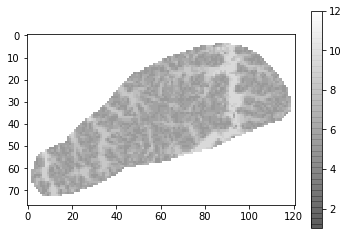

In [64]:
import matplotlib.cm as cm
#raster, shapes, extend_pixel, nodata=None, crop=False, all_touched=False,
#                invert=False
out_image, out_transform = mask_extend(src, class_JSON, (2,4), crop=True, invert=False, 
                                       crop_to_shape=True)

out_block = np.ones_like(out_image.data.squeeze()) + 90
out_block[::2, ::2] = 1
mask = out_image.mask == True # masked == True means masked.
#out_image.data[mask] = 0
out_image.data[out_image.data > 12] = 12

#plt.imshow(out_block, cmap=cm.gray, interpolation="none")
plt.imshow(out_image.data.squeeze(), cmap=cm.gray, alpha=0.4, interpolation="none") # schuh
plt.colorbar()
# draw rect as min bounding box
win = np.array(src.window(*mask_bounds))
rect = plt.Rectangle((win[1,0], win[0,0]), win[1,1]-win[1,0], win[0,1]-win[0,0],
                    linewidth=1,edgecolor='r',facecolor='none')
plt.gca().add_patch(rect)
#plt.savefig("nocrop.png")
plt.savefig("crop.png")
# extend out_image

In [65]:
t = out_transform
np.testing.assert_almost_equal(t.a, 0.0075)
np.testing.assert_almost_equal(t.b, 0.)
#np.testing.assert_almost_equal(t.c, 119.465) # 119.47107033875487 in v1.10
np.testing.assert_almost_equal(t.d, 0.)
np.testing.assert_almost_equal(t.e, -0.0075)
#np.testing.assert_almost_equal(t.f, -31.4075) # -31.409171275462175 in v1.10
print (119.47107033875487 - 119.465)
print (31.409171275462175 - 31.4075)

0.006070338754867066
0.0016712754621757142


In [66]:
(out_image.mask == False).any()

True

In [67]:
out_block[::2, ::2] = 1

In [68]:
np.set_printoptions(precision=10)
print out_transform.a, out_transform.e
#dlon = dpx/out_transform.a
#dlat = dpy/out_transform.e

print 
print src.transform[1], src.transform[5]

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(out_transform.a, out_transform.e)? (<ipython-input-68-987bee0fc53f>, line 2)

In [16]:
src.transform[5]

-0.007499999999999999

In [17]:
import numpy as np
sx = 7
sy = 7
r = sx/2

y,x = np.ogrid[-sy/2+1:sy/2+1, -sx/2+1:sx/2+1]
mask = x*x + y*y > r*r

mask*1

array([[1, 1, 1, 0, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 0, 1, 1, 1]])

In [18]:
mask2 = np.zeros_like(mask)
mask2[:2,:] = True
mask2



array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False]], dtype=bool)

In [19]:
mask | mask2

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True, False, False, False, False, False,  True],
       [False, False, False, False, False, False, False],
       [ True, False, False, False, False, False,  True],
       [ True, False, False, False, False, False,  True],
       [ True,  True,  True, False,  True,  True,  True]], dtype=bool)

In [20]:
import pandas as pd
import collections

# In[ ]:
class Stats(object):
    def __init__(self, csv_fname):
        self.df = None
        self.csv_fname = csv_fname
        #self.newline()
        self.d = collections.OrderedDict()

        try:
            self.df = pd.read_csv(self.csv_fname)
        except IOError:
            self.df = None  # collect info about runs: classifier name, training time ...

    def __setitem__(self, key, value):
        self.d[key] = value

    def __getitem__(self, key):
        return self.d[key]

    def newline(self):
        # write current line to csv?
        
        # add stats to dataframe
        if self.df is None:
            self.df = pd.DataFrame([self.d.values()], columns=self.d.keys()) # note [] around values
        else:
            self.df.loc[len(self.df)] = self.d.values()
        self.df.to_csv(self.csv_fname, index=False)

        self.d = collections.OrderedDict()


# In[ ]:
def test_stats():
    stats = Stats("s.csv")
    stats.newline()
    stats["five"] = 5
    stats["also"] = "bla"
    stats.newline()
    stats["five"] = 6

test_stats()
bla


ValueError: cannot set a frame with no defined columns

In [ ]:
s = Stats()
s['a'] = 5
print s['a']

In [ ]:
s.d